# Warp dataset samples

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('../')

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from genff.data_handling.dataset import GroupDataset

In [2]:
dataset = GroupDataset('../data/igibson_sim_data/env_Beechwood_0_int.h5')
print("Loaded {} examples".format(len(dataset)))

Loading ../data/igibson_sim_data/env_Beechwood_0_int.h5
Loaded 3000 examples


## Transforming the environment map

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(24, 24, 3)
[[ 0.4330127   0.25        3.80384758]
 [-0.5         0.8660254   7.60769515]]


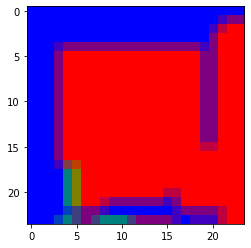

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(24, 24, 3)


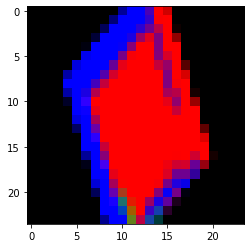

(24, 24, 3)


In [3]:
# work with one sample first

individual, context, mask, env = dataset[0]

env_tall = env[:,:,0] + env[:,:,2] # tall obstacles + unknown
image = torch.stack((env[:,:,1], env[:,:,3], env_tall), 2).numpy()
print(image.shape)

w = image.shape[0]
h = image.shape[1]

def make_transform(rows, cols, sx, sy, radians):
    """
    Compute 2x3 transformation matrix for cv2.warpAffine
    :param rows: number of rows in the environment map
    :param cols: number of columns in the environment map
    :param sx: horizontal scale (1 is no scale)
    :param sy: vertical scale (1 is no scale)
    :param radians: rotation in radians (0 is no rotation)
    :return: 2x3 numpy array for full env transform, and 2x2 array for centered pose transforms
    """
    T1 = np.array([[1.0, 0.0, w*0.5], 
                   [0.0, 1.0, h*0.5], 
                   [0.0, 0.0, 1.0]])
    S = np.array([[sx, 0.0, 0.0], 
                  [0.0, sy, 0.0], 
                  [0.0, 0.0, 1.0]])
    R = np.array([[np.cos(radians), np.sin(radians), 0.0], 
                  [-np.sin(radians), np.cos(radians), 0.0],
                  [0.0, 0.0, 1.0]])
    T2 = np.array([[1.0, 0.0, -w*0.5], 
                   [0.0, 1.0, -h*0.5], 
                   [0.0, 0.0, 1.0]])
    SR = S @ R
    M = T1 @ SR @ T2  # matrix multiply
    M = M[:2, :]  # 2 x 3 transform matrix
    return M, SR[:2, :2]
    
sx = 0.5
sy = 1.0
radians = 30.0 * np.pi / 180.0
M,_ = make_transform(image.shape[0], image.shape[1], sx, sy, radians)
print(M)

rotated = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]),
                         flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_CONSTANT,
                         borderValue=0)

plt.imshow(image)
plt.show()
print(image.shape)
plt.imshow(rotated)
plt.show()
print(rotated.shape)

## Transforming the poses

[[ 0.8660254   0.5       ]
 [-0.4         0.69282032]]


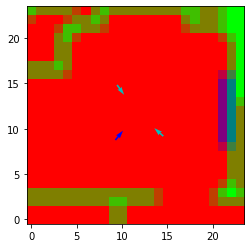

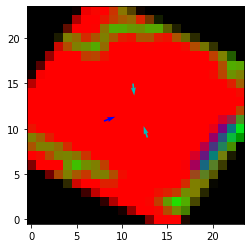

In [4]:
from genff.visualization.plotting import plot_sample, plot_sample_rect

def transform_env(M, env):
    """Transform environment"""
    new_env = cv2.warpAffine(env, M, (env.shape[1], env.shape[0]),
                             flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_CONSTANT,
                             borderValue=0)
    return new_env

def transform_poses(SR, radians, individual, context, x_index=0, y_index=1, angle_index=2):
    """
    Transform pose data
    """
    
    def transform_position(tt, input_tensor):
        out_tensor = torch.clone(input_tensor).to(input_tensor.device)
        out_tensor[:, [x_index, y_index]] = torch.matmul(out_tensor[:, [x_index, y_index]],tt)
        return out_tensor
   
    # rotate context
    tt = torch.tensor(SR.T, dtype=context.dtype).to(context.device)
    out_context = transform_position(tt, context)
    
    # rotate individual (not centered so we need to translate)
    T1 = np.array([[1.0, 0.0, individual[0, x_index].item()], 
                   [0.0, 1.0, individual[0, y_index].item()], 
                   [0.0, 0.0, 1.0]])
    T2 = np.eye(3)
    T2[:2,:2] = SR.T # we transpose it here because we are doing right multiply
    T3 = np.array([[1.0, 0.0, -individual[0, x_index].item()], 
                   [0.0, 1.0, -individual[0, y_index].item()], 
                   [0.0, 0.0, 1.0]])
    T = T1 @ T2 @ T3
    tt = torch.tensor(T[:2,:2], dtype=individual.dtype).to(individual.device)
    out_ind = transform_position(tt, individual)
    
    # angles
    out_ind[:, angle_index] = out_ind[:, angle_index] - radians
    out_context[:, angle_index] = out_context[:, angle_index] - radians
    
    return out_ind, out_context

individual, context, mask, env = dataset[400]

radians = 30.0 * np.pi / 180.0
M,SR = make_transform(env.shape[0], env.shape[1], 1.0, 0.8, radians)
print(SR)
new_env = torch.Tensor(transform_env(M, env.numpy()))
new_ind, new_con = transform_poses(SR, radians, individual, context)

plot_sample(individual, context, mask, env_cropped=env, env_res=dataset.resolution)
plt.show()

plot_sample(new_ind, new_con, mask, env_cropped=new_env, env_res=dataset.resolution)
plt.show()

## Making new h5 files with transformed data
See the bin/warp_data.py script. For example, it can be run as:
```bash
$ ./bin/warp_data.py -i data/igibson_sim_data/env_Beechwood_0_int.h5  --no-dyads --plot 
```